Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Iniciando o carregamento e pré-processamento dos dados...

Calculando os pesos das classes...
Pesos das classes: {0: 2.7481339704015766, 7: 136.91030545989747, 2: 6240.557449962936, 5: 6.195178570607255, 1: 4965.941306591948, 9: 2.1546656660971704, 6: 58259.598615916955, 8: 343.77058853555206}
Carregamento e pré-processamento concluídos. Tempo: 453.21 segundos
Iniciando o treinamento do modelo Random Forest...
Treinamento e avaliação concluídos. Tempo: 9403.37 segundos
Acurácia Balanceada: 0.9780
Macro F1-Score: 0.9806
Calculando a matriz de confusão...

Acurácia por classe:
Classe 0: 0.9612
Classe 1: 1.0000
Classe 2: 1.0000
Classe 3: nan
Classe 4: nan
Classe 5: 0.9995
Classe 6: 1.0000
Classe 7: 0.9874
Classe 8: 1.0000
Classe 9: 0.9834

Resumo de execução:
Tempo de carregamento e pré-processamento: 453.21 segundos
Tempo de treinamento e avaliação: 9403.37 seg

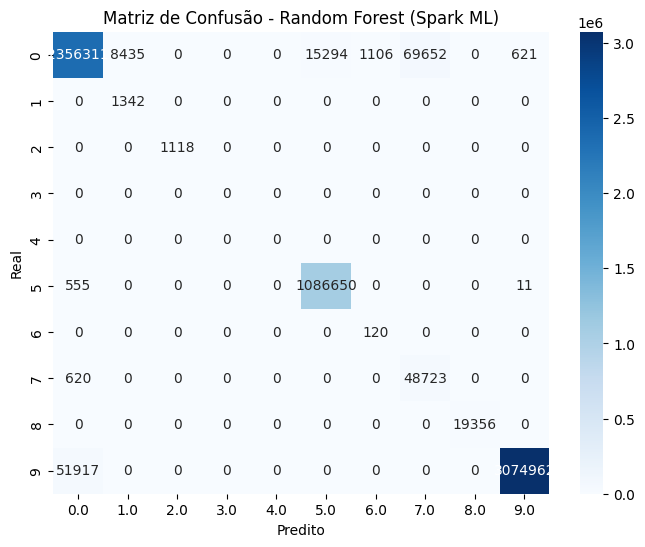

Execução concluída.


In [ ]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import lit, col, when
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from google.colab import drive

# 🚀 Montar o Google Drive
drive.mount('/content/drive')

# 📂 Caminho do arquivo no Google Drive
input_file = "/content/dados_limpos1.parquet"

# Configurar a sessão do Spark
spark = (
    SparkSession.builder
    .appName("PySparkRandomForestColab")
    .config("spark.executor.memory", "11g")
    .config("spark.driver.memory", "8g")
    .config("spark.sql.shuffle.partitions", "12")
    .getOrCreate()
)

# 🔹 Função para carregar e pré-processar os dados
def load_and_preprocess_data(file_path):
    start_time = time.time()
    print("Iniciando o carregamento e pré-processamento dos dados...")

    # Carregar os dados usando PySpark
    data = spark.read.parquet(file_path)

    # Filtrar classes relevantes (0 a 9)
    data = data.filter(data["class"].isin([0, 1, 2, 5, 6, 7, 8, 9]))

    # Montar o vetor de features
    feature_columns = [col for col in data.columns if col not in ["class", "state"]]
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    data = assembler.transform(data)

    # Normalizar as features
    scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
    scaler_model = scaler.fit(data)
    data = scaler_model.transform(data)

    # Calcular pesos das classes
    print("\nCalculando os pesos das classes...")
    class_counts = data.groupBy("class").count().toPandas()
    total_count = class_counts["count"].sum()
    class_weights = {row["class"]: total_count / row["count"] for _, row in class_counts.iterrows()}
    print(f"Pesos das classes: {class_weights}")

    # Adicionar a coluna de pesos ao dataset
    data = data.withColumn("classWeight", lit(1))
    for cls, weight in class_weights.items():
        data = data.withColumn(
            "classWeight",
            when(col("class") == cls, weight).otherwise(col("classWeight"))
        )

    elapsed_time = time.time() - start_time
    print(f"Carregamento e pré-processamento concluídos. Tempo: {elapsed_time:.2f} segundos")
    return data, elapsed_time

# 🔹 Função para treinar o modelo Random Forest e calcular matriz de confusão
def train_random_forest_and_confusion_matrix(data):
    start_time = time.time()
    print("Iniciando o treinamento do modelo Random Forest...")

    # Dividir os dados em treino e teste
    train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

    # Criar e treinar o modelo com pesos das classes
    rf = RandomForestClassifier(labelCol="class", featuresCol="scaledFeatures", weightCol="classWeight", numTrees=100, maxDepth=10)
    model = rf.fit(train_data)

    # Fazer previsões
    predictions = model.transform(test_data)

    # Avaliar o modelo
    evaluator_acc = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="f1")

    balanced_accuracy = evaluator_acc.evaluate(predictions)
    macro_f1_score = evaluator_f1.evaluate(predictions)

    elapsed_time = time.time() - start_time
    print(f"Treinamento e avaliação concluídos. Tempo: {elapsed_time:.2f} segundos")
    print(f"Acurácia Balanceada: {balanced_accuracy:.4f}")
    print(f"Macro F1-Score: {macro_f1_score:.4f}")

    # 📌 Criar a matriz de confusão
    print("Calculando a matriz de confusão...")
    confusion_df = (
        predictions.groupBy("class", "prediction")
        .count()
        .toPandas()
        .pivot(index="class", columns="prediction", values="count")
        .fillna(0)
    )

    # Garantir que todas as classes estão na matriz de confusão
    for cls in range(10):
        if cls not in confusion_df.index:
            confusion_df.loc[cls] = 0
        if cls not in confusion_df.columns:
            confusion_df[cls] = 0

    confusion_df = confusion_df.sort_index(axis=0).sort_index(axis=1)

    # Calcular a acurácia por classe
    total_per_class = confusion_df.sum(axis=1)
    correct_per_class = confusion_df.values.diagonal()
    accuracy_per_class = correct_per_class / total_per_class

    print("\nAcurácia por classe:")
    for cls, acc in enumerate(accuracy_per_class):
        print(f"Classe {cls}: {acc:.4f}")

    return model, elapsed_time, balanced_accuracy, macro_f1_score, confusion_df, accuracy_per_class

# 📌 Executar pipeline completo
overall_start_time = time.time()

# 📂 Etapa 1: Carregar e pré-processar os dados
data, preprocessing_time = load_and_preprocess_data(input_file)

# 🔥 Etapa 2: Treinar e avaliar o modelo
model, training_time, balanced_accuracy, macro_f1_score, confusion_df, accuracy_per_class = train_random_forest_and_confusion_matrix(data)

# 🔹 Exibir tempo total de execução
overall_elapsed_time = time.time() - overall_start_time
print("\nResumo de execução:")
print(f"Tempo de carregamento e pré-processamento: {preprocessing_time:.2f} segundos")
print(f"Tempo de treinamento e avaliação: {training_time:.2f} segundos")
print(f"Tempo total de execução: {overall_elapsed_time:.2f} segundos")
print(f"Acurácia Balanceada: {balanced_accuracy:.4f}")
print(f"Macro F1-Score: {macro_f1_score:.4f}")

# 📊 Exibir matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Random Forest (Spark ML)")
plt.show()

# Finalizar Spark
spark.stop()
print("Execução concluída.")

Classes 3 e 4 removidas da base no arquivo limpa_dados.py, basta modificalo para que a base seja criadado com todas as classes.

Essa verção do codigo foi feita para lidar com o fato de o codigo anterior falhar em classifcar as classes 6 minoritarias como a 6, apesar do alto desempenho em acuracia atingido no modelo anterior, esse novo modelo pode ser preferivel para aplicações reais.